In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# downloading datasets
zip_file = keras.utils.get_file(
    fname="cora.tgz",origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True
)
data_dir = os.path.join(os.path.dirname(zip_file),"cora")

In [3]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target","source"]
)
print(f"citations shape: {citations.shape}")

citations shape: (5429, 2)


In [4]:
citations.sample(frac=1).head()

,target,source
3057,40135,13686
5090,593328,87363
3088,41714,197054
3934,101143,596075
2315,20923,20924


In [5]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names
)
print(f"Papers Shape: {papers.shape}")

Papers Shape: (2708, 1435)


In [6]:
papers.head()

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [7]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

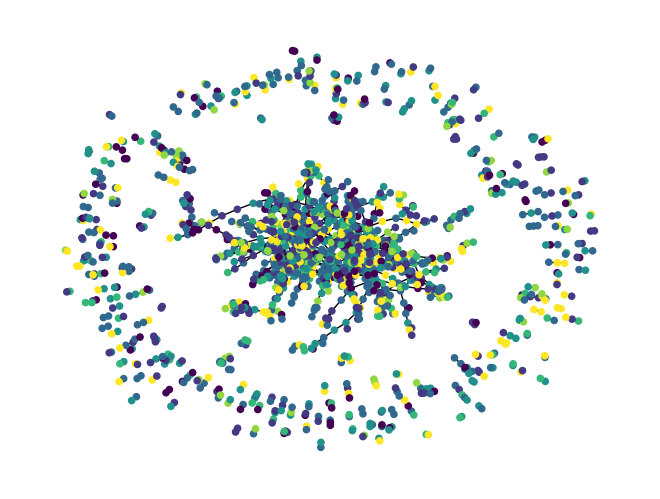

In [8]:
def plot_node():
    plt.figure()
    colors = papers["subject"].tolist()
    cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
    subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
    nx.draw_spring(cora_graph, node_size=20, node_color=subjects)

plot_node()

In [9]:
# splitting into training and testing
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print(f"Train data shape: {train_data.shape}\nTest data shape: {test_data.shape}")

Train data shape: (1369, 1435)
Test data shape: (1339, 1435)


In [10]:
# implementing train and evaluate experiment
hidden_units = [32,32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 400
batch_size = 256

In [11]:
def run_experiment(model, x_train, y_train):
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate),
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics = [keras.metrics.SparseCategoricalAccuracy(name="acc")]
    )

    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping]
    )
    return history

In [12]:
def display_learning_curves(history):
    fit, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train","test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [13]:
# implement feedforward network module
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(keras.layers.BatchNormalization())
        fnn_layers.append(keras.layers.Dropout(dropout_rate))
        fnn_layers.append(keras.layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [14]:
# prepare data for the baseline model
feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()

y_train = train_data["subject"]
y_test = test_data["subject"]

In [15]:
# implement baseline model
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = keras.layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx+2}")(x)
        x = keras.layers.Add(name=f"skip_connection{block_idx+2}")([x,x1])
    logits = keras.layers.Dense(num_classes, name="logits")(x)
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")

baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     [(None, 1433)]       0                                            
__________________________________________________________________________________________________
ffn_block1 (Sequential)         (None, 32)           52804       input_features[0][0]             
__________________________________________________________________________________________________
ffn_block2 (Sequential)         (None, 32)           2368        ffn_block1[0][0]                 
__________________________________________________________________________________________________
skip_connection2 (Add)          (None, 32)           0           ffn_block1[0][0]                 
                                                                 ffn_block2[0][0]          

In [31]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/400
5/5 [==============================] - 6s 249ms/step - loss: 4.1056 - acc: 0.1918 - val_loss: 1.9418 - val_acc: 0.1726
Epoch 2/400
5/5 [==============================] - 0s 77ms/step - loss: 2.9422 - acc: 0.2106 - val_loss: 1.9213 - val_acc: 0.1320
Epoch 3/400
5/5 [==============================] - 0s 64ms/step - loss: 2.4337 - acc: 0.2832 - val_loss: 1.8972 - val_acc: 0.2487
Epoch 4/400
5/5 [==============================] - 0s 42ms/step - loss: 2.2137 - acc: 0.2787 - val_loss: 1.8838 - val_acc: 0.2183
Epoch 5/400
5/5 [==============================] - 0s 44ms/step - loss: 2.0013 - acc: 0.2894 - val_loss: 1.8655 - val_acc: 0.2487
Epoch 6/400
5/5 [==============================] - 0s 71ms/step - loss: 1.9142 - acc: 0.3217 - val_loss: 1.8505 - val_acc: 0.1675
Epoch 7/400
5/5 [==============================] - 0s 46ms/step - loss: 1.7882 - acc: 0.3324 - val_loss: 1.8230 - val_acc: 0.2234
Epoch 8/400
5/5 [==============================] - 0s 53ms/step - loss: 1.7803 - acc: 0.3

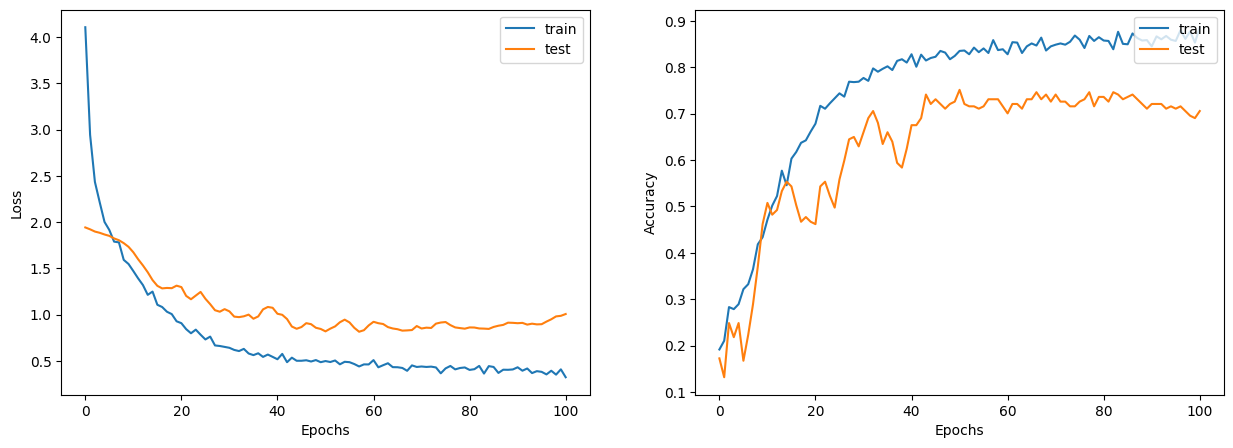

In [32]:
display_learning_curves(history)

In [33]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy*100, 2)}%")

Test accuracy: 74.77%
